In [ ]:
from data import *
from utils import *
import pandas as pd
import pygwalker as pyg

import neurokit2 as nk

train_data = np.load('/workspace/signal/PVC-NET_/dataset//mit-bih-arrhythmia-database-1.0.0_train_20230216.npy',allow_pickle=True) # B x (C) x Signal
valid_data = np.load('/workspace/signal/PVC-NET_/dataset/mit-bih-arrhythmia-database-1.0.0_valid_20230216.npy',allow_pickle=True) # B x (C) x Signal
test_data = np.load('/workspace/signal/PVC-NET_/dataset/mit-bih-arrhythmia-database-1.0.0_test_20230216.npy',allow_pickle=True) # B x (C) x Signal

AMC_data  = np.load('/workspace/signal/PVC-NET_/dataset/AMC_PeakLabel_3rd_125Hz.npy',allow_pickle=True) # 497 samples
CPSC2020_data  = np.load('/workspace/signal/PVC-NET_/dataset/CPSC2020_testSeg_ver2.npy',allow_pickle=True)
CU_data  = np.load('/workspace/signal/PVC-NET_/dataset/cu-ventricular-tachyarrhythmia-database-1.0.0_testSeg.npy',allow_pickle=True)
ESC_data  = np.load('/workspace/signal/PVC-NET_/dataset/european-st-t-database-1.0.0_testSeg.npy',allow_pickle=True)
FANTASIA_data = np.load('/workspace/signal/PVC-NET_/dataset/fantasia-database-1.0.0_testSeg.npy', allow_pickle=True) # B x (C) x Signal
INCART_data  = np.load('/workspace/signal/PVC-NET_/dataset/INCART_testSeg.npy',allow_pickle=True)
NS_data = np.load('/workspace/signal/PVC-NET_/dataset/mit-bih-noise-stress-test-database-1.0.0_testSeg.npy',allow_pickle=True)
STDB_data = np.load('/workspace/signal/PVC-NET_/dataset/mit-bih-st-change-database-1.0.0_testSeg.npy',allow_pickle=True)
SVDB_data = np.load('/workspace/signal/PVC-NET_/dataset/mit-bih-supraventricular-arrhythmia-database-1.0.0_testSeg.npy',allow_pickle=True)

In [ ]:
df = pd.read_csv(, parse_dates=['date'])
gwalker = pyg.walk(df)

In [ ]:
trainvalid_data = np.concatenate((train_data, valid_data))
np.save('mit-bih-arrhythmia-database-1.0.0_trainvalid_2023.npy',)

In [ ]:
len(train_data), len(valid_data), len(test_data), len(trainvalid_data)

In [ ]:
train_data = np.concatenate((train_data,STDB_data))
len(train_data)

In [ ]:
# data = FANTASIA_data
data = CU_data

print(len(data))
for i in range(len(data)):
    if len(data[i]['symbol_PVC'])!=0:
        print(i,data[i]['symbol_PVC'])

In [ ]:
!pip install monai==1.0.0

In [1]:
import os
gpus= "3"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpus
os.environ["WANDB_API_KEY"] = '6cd6a2f58c8f4625faaea5c73fe110edab2be208'

import monai
monai.__version__

'1.1.0'

In [112]:
from data import * 
import torch
import models
from models.unet import *
from models.densenet import *
from models.resnet import *
from models.efficientnet import *
from models.ffc import *
import monai

def draw_fft_plot(signal, sample_rate,label='',show=False,log=True):
    # Compute the FFT of the signal
    if len(signal.shape)==1:
        fft = torch.fft.fft(signal)
    elif len(signal.shape)==2:
        # get only 1st channel
        signal = signal[0]
        fft = torch.fft.fft(signal)
        
    # Compute the frequencies for the x-axis
    freqs = torch.fft.fftfreq(len(signal), 1/sample_rate) 
    
    # Plot the magnitude spectrum
    if log:
        # plt.magnitude_spectrum(signal, Fs=sample_rate,scale='dB', alpha=0.5, label=label)
        plt.magnitude_spectrum(freqs, Fs=sample_rate, scale='dB', alpha=0.5, label=label)
    plt.title('FFT Plot')
    # plt.xlim(0,5000)
    # plt.ylim(-140,-40)
    if label!='':
        plt.legend()
    if show:
        plt.show()
    

In [99]:
# net = densenet121(spatial_dims =1, in_channels=1, out_channels=2, module='SCM12')
# net

In [100]:
# net = resnet34(n_input_channels=1, spatial_dims=1, module='SCM12')

In [101]:
# net = EfficientNetBNFeatures(in_channels=1, model_name = 'efficientnet-b0', spatial_dims=1, module='SESCM12')


In [102]:
# weight['state_dict']

In [103]:
# net = UNet(spatial_dims =1, modelName= 'densenet121', in_channels=1, out_channels=2, encModule='SETFCAM32_11')
# net = UNet(spatial_dims =1, modelName= 'basic', in_channels=1, out_channels=2, encModule='TFCAM8_6')

# weight = torch.load('exp_20230410/encModuleTFCAM8_6_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/weight/best_val_loss.ckpt')
# net.load_state_dict(weight['state_dict'])
# # net = UNet(spatial_dims =1, modelName= 'resnet34', in_channels=1, out_channels=2, encModule='SETFCAM32_11')

In [113]:
config_defaults = dict(
    dataNorm ='zscoreO', # zscoreI, zscoreO, minmaxI
    modelName='basic', # 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'resnet34', 'densenet169', 'U2NET','U2NETP', 'basis'
    encModule = "SCM11", # "SE_BOTTOM5"
    decModule = "NONE", # "SE_BOTTOM5"
    segheadModule = "NONE",
    
    project = 'PVC-NET',  ########################## this is cutoff line of path_logRoot ##############################

    dataSeed = 1, # split seed
    srTarget = 250, # 
    featureLength = 1280,
    sampler = True, # True, False
    inChannels = 1,
    outChannels = 2,

    norm = 'instance', # 'instance', 'batch', 'group', 'layer'
    upsample = 'deconv', #'pixelshuffle', # 'nontrainable', 'deconv'
    supervision = "NONE", #'NONE', 'TYPE1', 'TYPE2'
    dropout = 0.1,
    mtl = 'NONE', # 'NONE', 'CLS, 'REC', 'ALL_avg', 'ALL_max'
    trainaug = 'NEUROKIT2',

    path_logRoot = 'exp_20230410',
    spatial_dims = 1,
    learning_rate = 1e-3,
    batch_size = 512, # 256
    thresholdRPeak = 0.7,
    lossFn = 'BCE',
)

from main import *
# path = 'exp_20230410/encModuleTFCAM8_6_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/weight/best_val_loss.ckpt'
# path = 'exp_20230410/encModuleTFCAM8_11_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/weight/best_val_loss.ckpt'
# path = 'exp_20230403/encModuleTFCAM8_6_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/weight/best_val_loss-v1.ckpt'
path = 'exp_20230410/encModuleTFCAM8_11_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/weight/best_val_loss.ckpt'

net = PVC_NET(config_defaults).load_from_checkpoint(path,strict=True)


saving path : exp_20230410/dataNormzscoreO_modelNamebasic_encModuleSCM11_decModuleNONE_segheadModuleNONE/
UNET encoder is basic
[64, 128, 256, 512, 512]
U-NET encModule is SCM11
U-NET mtl is NONE
U-NET decModule is NONE
U-NET supervision is NONE
U-NET segheadModule is NONE
saving path : exp_20230410/encModuleTFCAM8_11_dataNormzscoreO_modelNamebasic_decModuleNONE_segheadModuleNONE/
UNET encoder is basic
[64, 128, 256, 512, 512]
U-NET encModule is TFCAM8_11
U-NET mtl is NONE
U-NET decModule is NONE
U-NET supervision is NONE
U-NET segheadModule is NONE


In [114]:
# net.net.down_1.att.add_mod.return_weight = True
# net.net.down_2.att.add_mod.return_weight = True
# net.net.down_3.att.add_mod.return_weight = True
# net.net.down_4.att.add_mod.return_weight = True
net.net.down_5.att.add_mod.return_weight = True


In [115]:
# net.down_5.att.add_mod.return_weight = True

In [116]:
featureLength = 1280
srTarget = 250
classes = 2
dataNorm = 'zscore'
batch_size = 8

test_dataset = MIT_DATASET(test_data,featureLength, srTarget, classes, dataNorm, False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers=1, pin_memory=True)

iterator = iter(test_loader)

In [117]:
batch = iterator.next()
x = batch['signal']
y_seg = batch['y_seg']
y_PVC_seg = batch['y_PVC_seg']
y = batch['y_PVC']
x.shape, y

(torch.Size([8, 1, 4514]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [1]]))

In [118]:
# for i in range(len(x)):
#     plt.plot(x[i,0])
#     # plt.plot(y_seg[i,0],alpha=0.5)
#     plt.plot(y_seg[i,1],alpha=0.5)
#     plt.plot(y_PVC_seg[i,0])
#     plt.title(y[i])
#     plt.show()

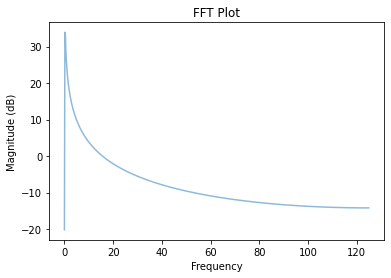

In [119]:

a = draw_fft_plot(x_[0,0],250)
a

torch.Size([8, 1, 4514]) torch.Size([1, 1, 1280]) torch.Size([8, 2, 4514]) torch.Size([1, 2, 1280]) tensor([1])


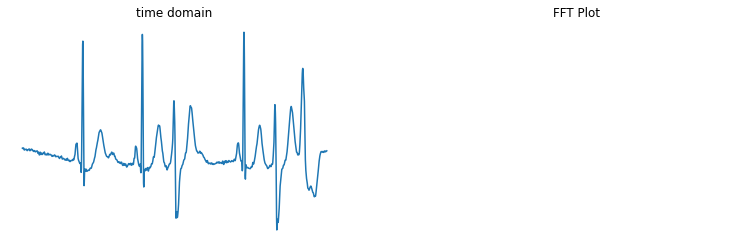

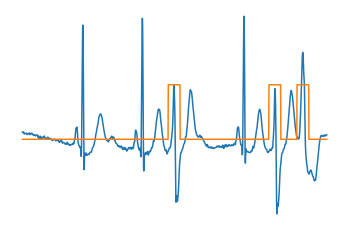

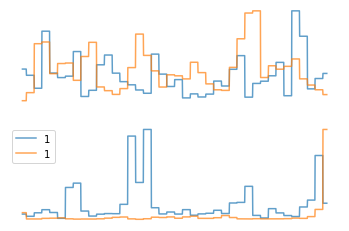

In [111]:
# x = torch.rand(1,1,1280)
idx = 5
start = 1000
end = start + 1280

x_ = x[idx:idx+1,:,start:end]
y_seg_ = y_seg[idx:idx+1,:,start:end]
print(x.shape,x_.shape, y_seg.shape, y_seg_.shape, y[idx])

plt.figure(figsize=(13.2,4))
plt.subplot(121)
plt.title('time domain')
plt.plot(x_[0,0])
plt.axis('off')

plt.subplot(122)
draw_fft_plot(x_[0,0],250)
plt.xlim(0,200)
plt.axis('off')
plt.show()

# plt.title('frequency domain')
# plt.subplot(121)
# plt.plot(x_[0,0])

# plt.subplot(122)
# draw_fft_plot(x_[0,0],250)
# plt.show()

plt.plot(x_[0,0])
plt.plot(y_seg_[0,1])
plt.axis('off')
plt.show()

yhat = net(x_)
# plt.plot(yhat[0,1].detach().numpy() )


In [60]:
for yh in yhat:
    print(yh.shape)

torch.Size([2, 1280])
